<a href="https://colab.research.google.com/github/mekhanikaladvantage/vneural-pdes/blob/main/pLap2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Imports
'''
!pip install optax #must be run at the start of the session.

from jax import jit, grad, vmap, value_and_grad, random, nn, jacfwd,jacrev
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import math
from matplotlib import cm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Variational p-Laplace Solver
The $p$-Laplace operator is the nonlinear counterpart to the Laplace operator. It is defined as
$$  \Delta_p u = \text{div}(\lvert \nabla u \rvert^{p-2} \nabla u)$$
The equation
$$\tag{♡} \Delta_p u = 0 $$
arises as the Euler-Lagrange equation that corresponds to the functional
$$ \mathcal{I}(u) = \int \lvert \nabla u \rvert^p dx$$
We undertake to solve a BVP involving (♡) by approximating $u$ using a neural net trained to minimize $\mathcal{I}(u)$.

NOTE: This code is not very user-friendly, but it does work.

# p-Laplace in 2-dimensions
We begin with a 2-dimensional example. We will try to solve
$$ \begin{cases} 
 \Delta_p u(x) = \text{div}(\lvert \nabla u(x) \rvert^{p-2} \nabla u(x))
 = 0  \quad &x \in \Omega = [-1,1]^2 \\
 u(x) = \lvert x \rvert - \lvert y \rvert \quad &x\in \partial\Omega \end{cases}$$
 for $p = 2,3,6$. If this is successful we will also move to higher and higher values of p get closer to the $\infty$-Laplacian, which has applications in image processing. $\Delta_\infty u$ can be explicitly represented in two dimensions, and this representation may be used to do a comparision with PINN later.

In [ ]:
key, subkey = random.split(random.PRNGKey(0))

In [ ]:
'''
Hyperparameters
'''
# THIS CELL MUST BE RUN THE RESET THE PARAMETERS OF THE NETWORK

# this creates random parameters for the weights and biases of a given node
def random_layer_params(m:int,n:int,key, scale = 1e-01) -> tuple:
    w_key, b_key = random.split(key)

    minval = -6/(jnp.sqrt(m + n))

    maxval = -1*minval

    w = scale * random.uniform(w_key,(n,m),minval = minval,maxval = maxval)
    b = scale * random.uniform(b_key,(n,),minval = minval,maxval = maxval)
    return w,b 

# this should initalize nodes
def init_network_params(sizes:list,key) -> list:
    keys = random.split(key, len(sizes))
    return [random_layer_params(m,n,k) for m,n,k in zip(sizes[:-1],sizes[1:],keys)]


hypers = dict()
hypers["d"] = 2
hypers["m"] = 50
# hypers["m"] = 20 #for resnet
hypers["step size"] = 1e-04
hypers["num epochs"] = 20000
hypers["batch size"] = 256
hypers["boundary size"] = 256
hypers["beta"] = 1
hypers["p"] = 100 #p in p-laplace. 

# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],1]

layer_sizes = [hypers["d"],hypers["m"],hypers["m"],1] # 1 HL
# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],1] # 2 HL
# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],1] # 3 HL
#resnet architecture:
#3 blocks
# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],1]

params = init_network_params(layer_sizes,random.PRNGKey(0))
params = init_network_params(layer_sizes,subkey)


key, subkey = random.split(key) #this enables us to not fix the initial parameters

optimizer = optax.adam(learning_rate = hypers["step size"])
# 

In [ ]:
'''
model
'''
from jaxlib.xla_extension import DeviceArray
compiled_celu = jit(nn.celu)
compiled_softplus = jit(nn.softplus)


def relu3(x) -> np.float32:
  return jnp.maximum(0,x**3)

def model(params:list,x:DeviceArray) -> np.float32:
    # print("shape of ijnput is {}".format(x.shape))
    '''
    params: list of weight, bias tuples. 
    x: Input vector. Should be shape (2,)
    x[0] is x coord, x[1] is y coord.
    '''

    w,b = params[0]
    output = jnp.dot(w,x) + b
    activations = relu3(output)
    residual = activations #will be used for skip connection, needs right dim  
    for w,b in params[1:-1]: #first and last params are for linear transformation
        output = jnp.dot(w,activations) + b
        activations = relu3(output)   
        
    final_w,final_b = params[-1] 
    logits = jnp.dot(final_w,activations) + final_b
    return logits[0]


    #######

batched_model = vmap(model,in_axes=(None,0)) #maps dim(2,128) -> dim(128)

In [ ]:
x = jnp.array([1.0,0.5])
out = model(params,x) # 0.004663214
print(out)

0.03757536


In [ ]:
key, subkey = random.split(random.PRNGKey(0))
#  #need static argums batch dim size

nudge = jnp.finfo(np.float32).tiny
print(nudge)

def get_batch(batch_size:int,key:DeviceArray) -> DeviceArray:
  return random.uniform(key,shape = (batch_size,hypers["d"]),minval=jnp.nextafter(-1,jnp.inf),maxval=1)



ones = jnp.ones(shape=(hypers["boundary size"],))
slit_size = int(hypers["boundary size"]/2)
zeros = jnp.zeros(shape=(slit_size,))


def get_boundary_batch(bdy_batch_size:int,key:DeviceArray) -> DeviceArray:
  keys = random.split(key,num=5)

  high_end = jnp.nextafter(1,jnp.inf) # to include 1 in sample
  # high_end = 1 + nudge

  top_sample = random.uniform(keys[0],shape=(bdy_batch_size,),minval=-1,maxval=high_end)
  # print(top_sample.shape)
  top = jnp.stack((top_sample,ones),axis=1)

  right_sample = random.uniform(keys[1],shape=(bdy_batch_size,),minval=-1,maxval=high_end)
  right = jnp.stack((ones,right_sample),axis=1)

  bot_sample = random.uniform(keys[2],shape=(bdy_batch_size,),minval=-1,maxval=high_end)
  bot = jnp.stack((bot_sample,-1*ones),axis=1)

  left_sample = random.uniform(keys[3],shape=(bdy_batch_size,),minval=-1,maxval=high_end)
  left = jnp.stack((-1*ones,left_sample),axis=1)

  boundary = jnp.concatenate((top,right,bot,left),axis=0)

  return boundary

  # return (all_bdy_xs,all_bdy_ys)

# ones = jnp.ones(shape=(4,))
# zeros = jnp.zeros(shape=(4),)
boundary = get_boundary_batch(hypers["boundary size"],subkey)
# interior = get_batch(4,subkey)
# print(interior)
print(boundary[:5])
print(f"{x,y}" for x,y in boundary[:5])

1.1754944e-38
[[ 0.53696775  1.        ]
 [-0.40355515  1.        ]
 [ 0.34293818  1.        ]
 [ 0.8892424   1.        ]
 [-0.95185256  1.        ]]
<generator object <genexpr> at 0x7fd6d56640b0>


In [ ]:
'''
loss and update block
'''

from optax._src.base import OptState
from chex._src.pytypes import Device
from jax._src.random import KeyArray

def bdy_exact(batch:DeviceArray) -> DeviceArray:
  return jnp.array([jnp.abs(x[0]) - jnp.abs(x[1]) for x in batch])

'''
error comparision
'''
def hessian(f):
  return jacfwd(jacrev(f,argnums=1),argnums=1)


def u_exact(input:DeviceArray) -> DeviceArray:
  return jnp.array([(jnp.abs(x[0])**4)**(1/3) - (jnp.abs(x[1])**(4))**(1/3) for x in input]) #exact sol u = x^4/3 - y^4/3

def infLap(x:DeviceArray) -> DeviceArray:
  D2u = hessian(model)(params,x) #obtain Hessian
  [dudx,dudy] = grad(model,1)(params,x) # get gradient for first derivs


  return jnp.add((dudx**2)*(D2u[0,0]), jnp.add(2*dudx*dudy*D2u[1,0],(dudy**2)*D2u[1,1]))

def flow_loss_fn(params:list,x:DeviceArray) -> np.float32:
  '''
  flow loss calculated on 1 2D sample in order for 
  autograd to work on the model. Autograd needs scalar output.
  '''
  dudx = grad(model,argnums=1)(params,x) # compute gradient wrt sample
  return 1/hypers["p"]*(jnp.sum(dudx*dudx)**(hypers["p"]/2))
  

flow_loss_vector = vmap(flow_loss_fn,in_axes=(None,0)) 
infLapVector = vmap(infLap,in_axes=0)

def loss_fn(params:list,key:KeyArray) -> np.float32:
  '''
  this function samples data and calculates the loss.
  Please note that this function must be differentiable.
  The loss consists of two parts, an flow loss given by the energy,
  and a boundary loss to enforce boundary conditions. 
  '''
  # generate data
  keys = random.split(key,num=2)
  interior_sample = get_batch(hypers["batch size"],keys[0])
  boundary_sample = get_boundary_batch(hypers["boundary size"],keys[1])
  


  #calculate flow loss - variational
  flow_output = flow_loss_vector(params,interior_sample)
  flow_loss = jnp.mean(flow_output) 

  #For PINN loss
  # flow_output = infLapVector(interior_sample)
  # flow_loss = jnp.linalg.norm(flow_output,2)

  #calculate boundary loss
  bdy_output = batched_model(params,boundary_sample)
  bdy_diff = batched_model(params,boundary_sample) - bdy_exact(boundary_sample)
  bdy_loss = hypers["beta"]*jnp.mean((bdy_diff*bdy_diff))

  return jnp.add(flow_loss,bdy_loss)

def update(params:list,opt_state:OptState,key:KeyArray):
  '''
  This calculates the parameter updates using the ADAM algorithm,
  as implemented in optax.
  '''

  loss,grads = value_and_grad(loss_fn,argnums=0)(params,key)

  updates,opt_state = optimizer.update(grads,opt_state,params)
  params = optax.apply_updates(params,updates)

  return params,opt_state,loss

#jit update for moar speed
compiled_update = jit(update) 



In [ ]:
# model debugging
# print(params[0])

x = jnp.array([1.0, 0.75])
out_test = flow_loss_fn(params,x)
# out_test = model(params,x)
print(out_test)

# key = random.PRNGKey(2)
# loss = loss_fn(params,key)
# print(loss)

glue = jnp.ones(shape=(3,1))
gluee = jnp.ones(shape = (3,))
# print(glue)
# print(gluee + gluee)
foo = jnp.reshape(jnp.arange(0,9),(3,3))
bar = jnp.dot(foo,gluee)
# print(bar + gluee)
# print(bar + glue)
baz = jnp.dot(foo,(bar+glue))
# print(baz)

byoom = jnp.dot(foo,(bar+gluee))
# print(byoom)

# input = jnp.array([[0.5,0],[1,.5]])
input = jnp.array([0.5,0])

# whatever = jnp.array([jnp.abs(x[0]) - jnp.abs(x[1]) for x in input])
test = infLap(input)
testVector = jnp.reshape(jnp.double(jnp.arange(0,10,dtype=float)),(5,2))

vectorOutput = infLapVector(testVector)
print(vectorOutput)

0.0
[-1.2204844e-21 -2.1880059e-19 -1.0913031e-16 -4.4045883e-14
 -1.6514491e-11]


## Training block


In [ ]:
#reset key
key, train_key = random.split(random.PRNGKey(0))
params = init_network_params(layer_sizes,train_key)
%xmode context


Exception reporting mode: Context


---------------
Epoch 0 in 12.92 additional seconds
Flow loss is 0.0
Boundary loss is 0.3457065224647522
Model error is 1.0017231702804565
Total loss is 0.34571462869644165
---------------
Epoch 1000 in 1.90 additional seconds
Flow loss is 0.02279707044363022
Boundary loss is 0.11305360496044159
Model error is 0.6240949630737305
Total loss is 0.1359921246767044
---------------
Epoch 2000 in 1.94 additional seconds
Flow loss is 0.014631552621722221
Boundary loss is 0.07328969240188599
Model error is 0.5312368869781494
Total loss is 0.08795657008886337
---------------
Epoch 3000 in 1.90 additional seconds
Flow loss is 0.01671602949500084
Boundary loss is 0.054029300808906555
Model error is 0.47344696521759033
Total loss is 0.07076001167297363
---------------
Epoch 4000 in 1.89 additional seconds
Flow loss is 0.016755396500229836
Boundary loss is 0.053110573440790176
Model error is 0.4634864926338196
Total loss is 0.06987382471561432
---------------
Epoch 5000 in 2.12 additional seconds
F

<Figure size 640x480 with 0 Axes>

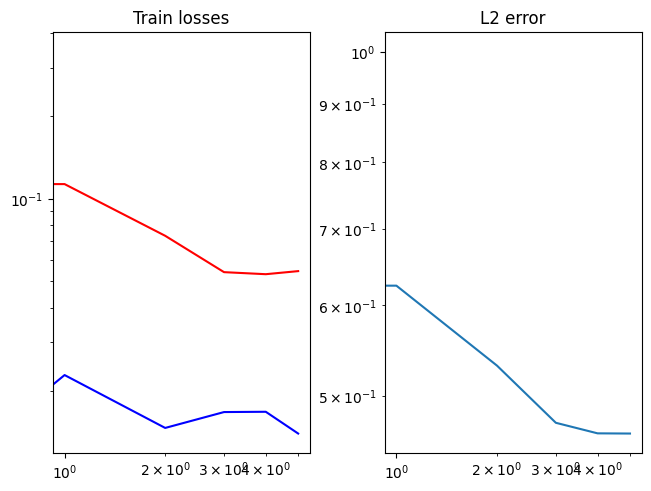

---------------
Epoch 6000 in 2.92 additional seconds
Flow loss is 0.0185793936252594
Boundary loss is 0.051945000886917114
Model error is 0.4625273644924164
Total loss is 0.07058106362819672
---------------
Epoch 7000 in 1.90 additional seconds
Flow loss is 0.015469642356038094
Boundary loss is 0.05170821771025658
Model error is 0.4630095660686493
Total loss is 0.06719152629375458
---------------
Epoch 8000 in 2.05 additional seconds
Flow loss is 0.018154317513108253
Boundary loss is 0.051900800317525864
Model error is 0.45955392718315125
Total loss is 0.0700865387916565
---------------
Epoch 9000 in 1.91 additional seconds
Flow loss is 0.016376931220293045
Boundary loss is 0.05244913697242737
Model error is 0.4598671495914459
Total loss is 0.06882675737142563
---------------
Epoch 10000 in 1.96 additional seconds
Flow loss is 0.014862097799777985
Boundary loss is 0.05405355617403984
Model error is 0.4620635211467743
Total loss is 0.0689208060503006


<Figure size 640x480 with 0 Axes>

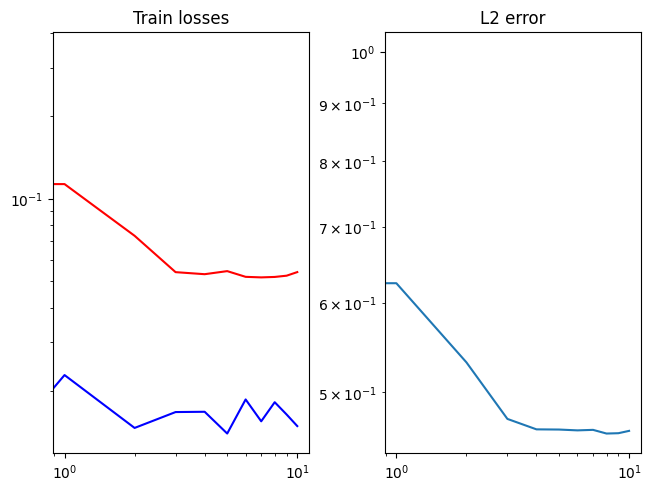

---------------
Epoch 11000 in 3.18 additional seconds
Flow loss is 0.014561368152499199
Boundary loss is 0.049255430698394775
Model error is 0.4592675268650055
Total loss is 0.06382614374160767
---------------
Epoch 12000 in 2.49 additional seconds
Flow loss is 0.01600811630487442
Boundary loss is 0.05506382882595062
Model error is 0.4606999456882477
Total loss is 0.07107236981391907
---------------
Epoch 13000 in 1.87 additional seconds
Flow loss is 0.017971638590097427
Boundary loss is 0.0534755103290081
Model error is 0.4568878710269928
Total loss is 0.07143956422805786
---------------
Epoch 14000 in 1.92 additional seconds
Flow loss is 0.015541327185928822
Boundary loss is 0.05309377610683441
Model error is 0.4627130627632141
Total loss is 0.06864781677722931
---------------
Epoch 15000 in 2.02 additional seconds
Flow loss is 0.0186296496540308
Boundary loss is 0.0518658310174942
Model error is 0.4620400667190552
Total loss is 0.0705224946141243


<Figure size 640x480 with 0 Axes>

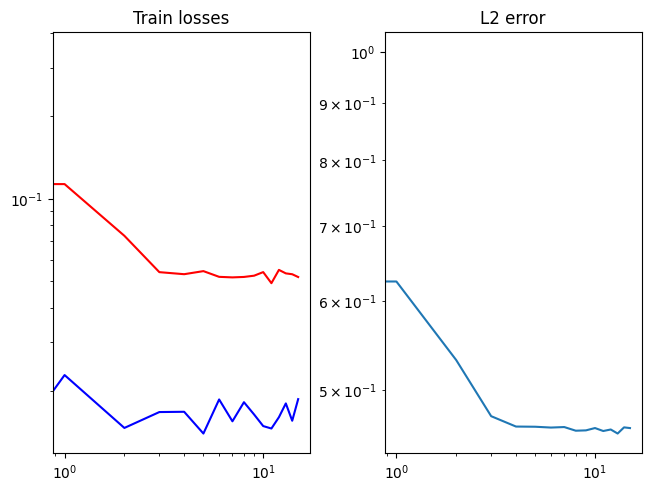

---------------
Epoch 16000 in 2.85 additional seconds
Flow loss is 0.015338718891143799
Boundary loss is 0.05332709103822708
Model error is 0.45925354957580566
Total loss is 0.06867662817239761
---------------
Epoch 17000 in 1.92 additional seconds
Flow loss is 0.01573125086724758
Boundary loss is 0.05230589210987091
Model error is 0.46105003356933594
Total loss is 0.06804392486810684
---------------
Epoch 18000 in 2.18 additional seconds
Flow loss is 0.01631072163581848
Boundary loss is 0.04953814297914505
Model error is 0.45991775393486023
Total loss is 0.06585326790809631
---------------
Epoch 19000 in 2.17 additional seconds
Flow loss is 0.016163576394319534
Boundary loss is 0.054812777787446976
Model error is 0.458429753780365
Total loss is 0.07099515199661255
Epoch 19999 in 2.17 sec
Final loss is  0.06600558757781982
final error is 0.458429753780365


In [ ]:
#training loop
import time


training_losses = []
flow_losses = []
boundary_losses = []
residuals = []


#adam optimizer via optax
opt_state = optimizer.init(params)
start_time = time.time()

# checkpoint_params=0
num_of_samples=100
x_range = jnp.linspace(-1,1,num=num_of_samples) #inclusive on ijnputs and outputs
[Xs,Ys] = jnp.meshgrid(x_range,x_range)
temp_output = np.zeros(shape=(num_of_samples,num_of_samples))



for epoch in range(hypers["num epochs"]):
    
    key,train_key = random.split(key)   
    params,opt_state,train_loss = compiled_update(params,opt_state,train_key)
    training_losses.append(train_loss)
    
    if epoch%1000 == 0:
      

      epoch_time = time.time() - start_time

      keys = random.split(train_key,num=2)
      int_out_batch = get_batch(hypers["batch size"],keys[0])
      bdy_out_batch = get_boundary_batch(hypers["boundary size"],keys[1])

      flow_output = flow_loss_vector(params,int_out_batch)     
      flow_train_loss = jnp.mean(flow_output)    

      flow_losses.append(flow_train_loss)
      bdy_output = batched_model(params,bdy_out_batch)
      bdy_diff = batched_model(params,bdy_out_batch) - bdy_exact(bdy_out_batch)
      bdy_train_loss = hypers['beta']*jnp.mean((bdy_diff*bdy_diff))
      boundary_losses.append(bdy_train_loss)
      out_batch = jnp.concatenate((int_out_batch,bdy_out_batch),axis=0)
      exact_output = u_exact(out_batch)
      error_now = jnp.linalg.norm(batched_model(params,out_batch) - u_exact(out_batch),2)/jnp.linalg.norm(u_exact(out_batch),2)
      residuals.append(error_now)

      start_time = time.time()
      print("---------------")
      print("Epoch {} in {:0.2f} additional seconds".format(epoch, epoch_time))
      
      print(f'Flow loss is {flow_train_loss}')
      print(f'Boundary loss is {bdy_train_loss}')
      print(f'Model error is {error_now}')
      print("Total loss is {}".format(train_loss))
    #end if

    if epoch%5000 == 0 and epoch != 0:
      plt.clf()
      fig, axs = plt.subplots(nrows=1,ncols=2,layout="constrained")
      axs[0].loglog(flow_losses,c='b')
      axs[0].set_title("Train losses")
      axs[0].loglog(boundary_losses,c='r')
      axs[1].loglog(residuals)
      axs[1].set_title("L2 error")
      plt.show()
    #end if

#end for
    
#once loops ends    
print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time)) #print final epoch info
print("Final loss is  {}".format(train_loss))
print(f'final error is {residuals[-1]}')


final error is 0.458429753780365


<Figure size 640x480 with 0 Axes>

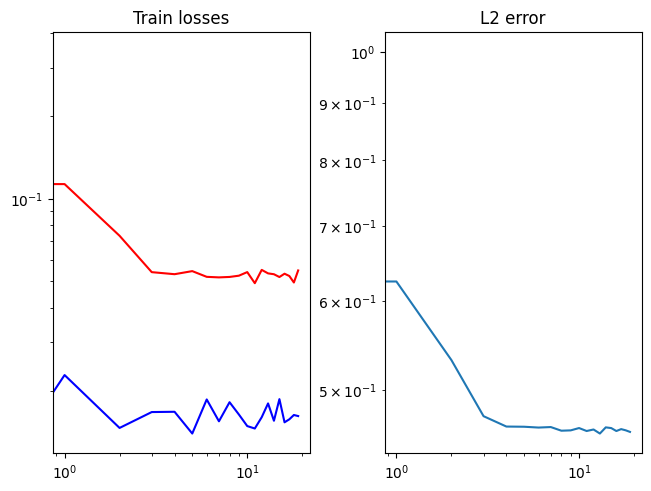

In [ ]:
print(f'final error is {residuals[-1]}')
plt.clf()
fig, axs = plt.subplots(nrows=1,ncols=2,layout="constrained")
axs[0].loglog(flow_losses,c='b')
axs[0].set_title("Train losses")
axs[0].loglog(boundary_losses,c='r')
axs[1].loglog(residuals)
axs[1].set_title("L2 error")
plt.savefig("train_error_10lap3hlw50s10.png")
plt.show()


<Figure size 640x480 with 0 Axes>

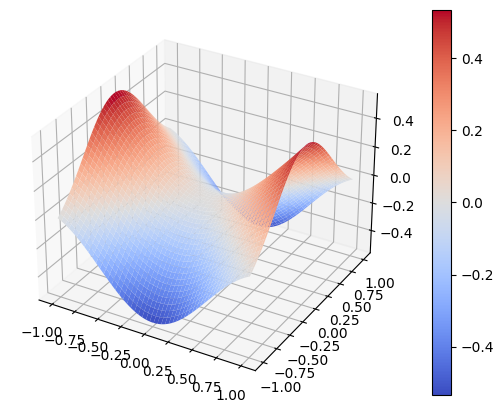

In [ ]:
plt.clf()
for i in range(num_of_samples):
  xRow = Xs[i,:]
  yRow = Ys[i,:]
  vector_to_eval = jnp.stack((xRow,yRow),axis=1)
  temp_output[i,:] = batched_model(params,vector_to_eval)
      #end for
fig = plt.figure()
axs = fig.add_subplot(projection='3d')
fig.set_size_inches(9.5,5)
graph_output = axs.plot_surface(Xs,Ys,temp_output,cmap=cm.coolwarm)

fig.colorbar(graph_output)
      # axs[0].scatter(int_out_batch[:,0],int_out_batch[:,1],c='b')
      # axs[0].scatter(bdy_out_batch[:,0],bdy_out_batch[:,1],c='r')
plt.show()
# contour = fig.add_subplot()


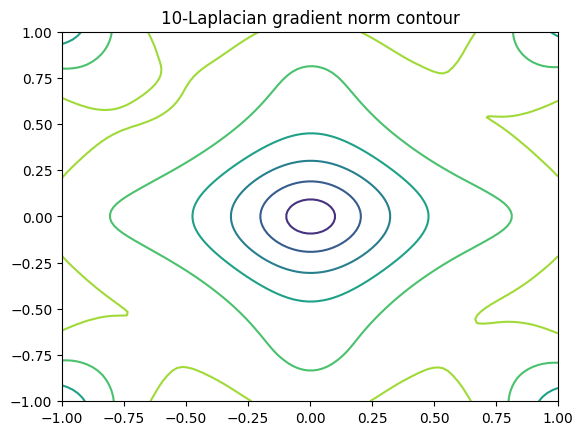

In [ ]:
def norm_grad(params:list,x:DeviceArray):
  Du = grad(model,argnums=1)(params,x)
  return jnp.linalg.norm(Du)
plt.clf()
batch_norm_grad = vmap(norm_grad,in_axes=(None,0))
contour_output = np.zeros(shape=(num_of_samples,num_of_samples))
# contour_output = [norm_grad(params,jnp.array([x,y])) for (x,y) in zip(Xs,Ys)] #one day my sweet prince
for i in range(num_of_samples):
  xRow = Xs[i,:]
  yRow = Ys[i,:]
  vector_to_eval = jnp.stack((xRow,yRow),axis=1)
  contour_output[i,:] = batch_norm_grad(params,vector_to_eval)
#end for  

plt.contour(Xs,Ys,contour_output)
# plt.xlim(-0.5, 0.5)
# plt.ylim(-0.5,0.5)
plt.title(f"{hypers['p']}-Laplacian gradient norm contour")
plt.savefig("10lap-contour-1hlw50.png")
plt.show()


In [ ]:
plt.clf()
diff_output = np.zeros(shape=(num_of_samples,num_of_samples))
for i in range(num_of_samples):
  xRow = Xs[i,:]
  yRow = Ys[i,:]
  vector_to_eval = jnp.stack((xRow,yRow),axis=1)
  diff_output[i,:] = u_exact(vector_to_eval) - batched_model(params,vector_to_eval)
      #end for


# boundary looks right!

<Figure size 640x480 with 0 Axes>

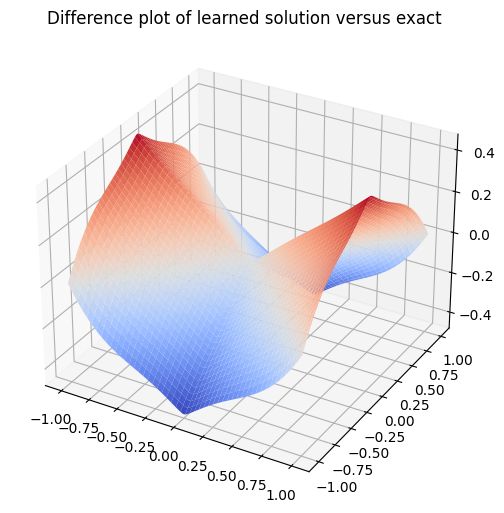

In [ ]:
fig = plt.figure(layout='constrained')
axs = fig.add_subplot(projection='3d')
fig.set_size_inches(9.5,5)

axs.plot_surface(Xs,Ys,diff_output,cmap=cm.coolwarm)
plt.title("Difference plot of learned solution versus exact")
# plt.savefig("Diffrnc-plt-200lap1hlw50s20.png")
plt.show()